# Predicting Water Pump Functionality in Tanzania (HydroLogic Project)
Authored by Farzaneh Gerami, Subaye Opoku-Acquah & Mariam Farda | 
March – June 2025

# Imports

In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway

import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind # checking if the data is random or depends on other

import joblib


# Sprint 1 - Data Cleaning and Preprocessing

## Read Merged Data

In [37]:
# Read Merged data as an original data
url_merge_data = "../data/processed/cleaned_Training_data.csv"
df_train = pd.read_csv(url_merge_data)
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group,year_recorded,month_recorded,dayofweek_recorded
0,69572,6000.0,2011-03-14,roman,1390.0,roman,34.938093,-9.856322,none,Lake Nyasa,...,soft,good,enough,spring,groundwater,communal standpipe,functional,2011,3,0
1,8776,0.0,2013-03-06,grumeti,1399.0,grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,...,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,2013,3,2
2,34310,25.0,2013-02-25,lottery club,686.0,world vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,soft,good,enough,dam,surface,communal standpipe multiple,functional,2013,2,0
3,67743,0.0,2013-01-28,unicef,263.0,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,2013,1,0
4,19728,0.0,2011-07-13,action in a,0.0,artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,2011,7,2


In [38]:
df_train.shape

(47520, 36)

# Analyze Cardinality of Categorical Features

In [39]:
# Summary of categorical columns
cat_summary = df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)
print(cat_summary)


wpt_name                 30761
scheme_name               2512
ward                      2087
installer                 1709
funder                    1679
subvillage                1679
date_recorded              352
lga                        125
construction_year           54
region                      21
management                  12
scheme_management           11
permit                      11
source                      10
basin                        9
water_quality                8
extraction_type_class        7
payment_type                 7
waterpoint_type              7
quality_group                6
management_group             5
quantity                     5
source_class                 3
status_group                 3
dtype: int64


# categorize them as low or high cardinality

In [40]:
# Recalculate high cardinality columns
high_card_cols = cat_summary[cat_summary > 10].index.tolist()
high_card_cols

['wpt_name',
 'scheme_name',
 'ward',
 'installer',
 'funder',
 'subvillage',
 'date_recorded',
 'lga',
 'construction_year',
 'region',
 'management',
 'scheme_management',
 'permit']

In [41]:


# Select low cardinality columns (2–10 unique values)
low_card_cols = cat_summary[(cat_summary <= 10) & (cat_summary > 1)].index.tolist()
low_card_cols


['source',
 'basin',
 'water_quality',
 'extraction_type_class',
 'payment_type',
 'waterpoint_type',
 'quality_group',
 'management_group',
 'quantity',
 'source_class',
 'status_group']

## Define Encoding Strategy
- High Cardinality: use the frequency or lable strategy, keeps dimensionality low
(wpt_name, subvillage, scheme_name, ward, date_recorded, lga, region, extraction_type, extraction_type_group, management, installer, funder, scheme_management)

- Low Cardinality: one-Hot Encoding strategy, preffered for non-ordinal categories
(source, basin, water_quality, source_type, waterpoint_type, extraction_type_class, payment_type, payment, quality_group, waterpoint_type_group, quantity, quantity_group, management_group, source_class, status_group)

- Boolean-like string, Map to 0/1. 
(permit or public_meeting)

## Implement Encoding

In [42]:
# Create a copy for encoding
df_encoded = df_train.copy()

## One-Hot Encode Low Cardinality Columns

In [43]:
# Apply One-Hot Encode Low Cardinality
df_encoded = pd.get_dummies(df_encoded, columns=low_card_cols, drop_first=True)

# Preview result
print(f"Total new shape: {df_encoded.shape}")
print("First few column names:", df_encoded.columns[:10].tolist())

Total new shape: (47520, 84)
First few column names: ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'subvillage']


## Frequency Encode High Cardinality Columns

In [44]:
# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_encoded[col].value_counts().to_dict()
    df_encoded[col + '_freq'] = df_encoded[col].map(freq_map)

In [45]:
# Check result
print("Final encoded shape:", df_encoded.shape)
df_encoded.head()

Final encoded shape: (47520, 97)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,subvillage,...,installer_freq,funder_freq,subvillage_freq,date_recorded_freq,lga_freq,construction_year_freq,region_freq,management_freq,scheme_management_freq,permit_freq
0,69572,6000.0,2011-03-14,roman,1390.0,roman,34.938093,-9.856322,none,roman,...,72,217,217,394,463,773,4267,32395,31718,31718
1,8776,0.0,2013-03-06,grumeti,1399.0,grumeti,34.698766,-2.147466,Zahanati,grumeti,...,29,39,39,107,554,2135,1550,5212,597,597
2,34310,25.0,2013-02-25,lottery club,686.0,world vision,37.460664,-3.821329,Kwa Mahundi,lottery club,...,573,7,7,218,246,2012,1258,32395,31718,31718
3,67743,0.0,2013-01-28,unicef,263.0,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,unicef,...,190,860,860,296,126,334,1402,32395,31718,31718
4,19728,0.0,2011-07-13,action in a,0.0,artisan,31.130847,-1.825359,Shuleni,action in a,...,113,1,1,203,622,8463,2677,672,31718,31718


In [46]:
# drop the original: 
df_encoded.drop(columns=high_card_cols, inplace=True)

In [47]:
# Save the Mapping for Test Set
joblib.dump(freq_map, 'funder_freq_map.pkl')

['funder_freq_map.pkl']

# Check for and Handle Outliers in Numerical Features

## Identify Numerical Columns

In [48]:
# Get numeric columns, but exclude ID or code-like columns
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
excluded = ['id', 'region_code', 'district_code']  # Don't plot these
numeric_cols = [col for col in numeric_cols if col not in excluded]
numeric_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'year_recorded',
 'month_recorded',
 'dayofweek_recorded',
 'wpt_name_freq',
 'scheme_name_freq',
 'ward_freq',
 'installer_freq',
 'funder_freq',
 'subvillage_freq',
 'date_recorded_freq',
 'lga_freq',
 'construction_year_freq',
 'region_freq',
 'management_freq',
 'scheme_management_freq',
 'permit_freq']

# Visualize Distributions

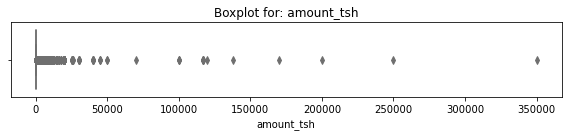

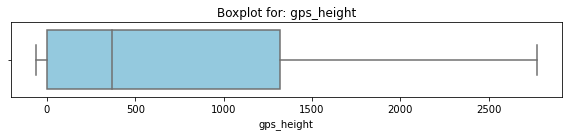

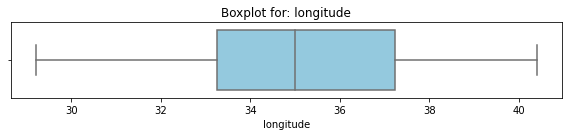

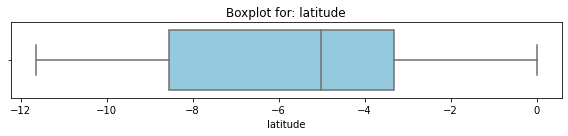

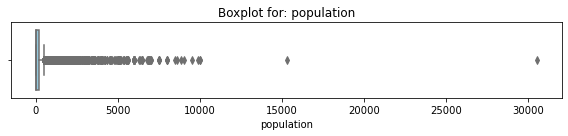

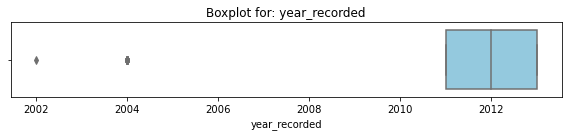

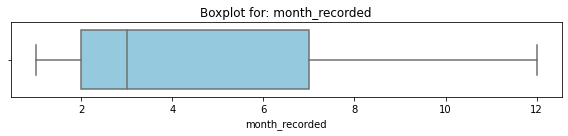

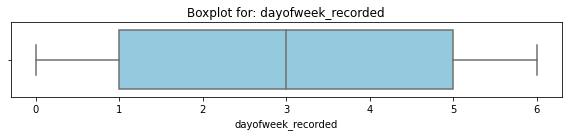

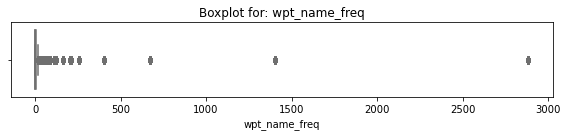

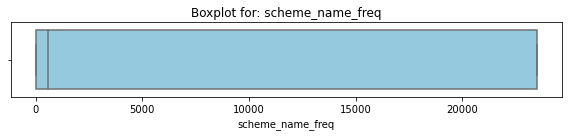

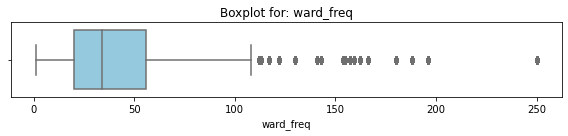

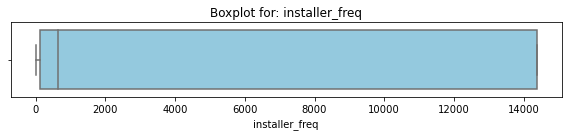

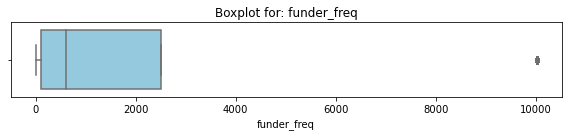

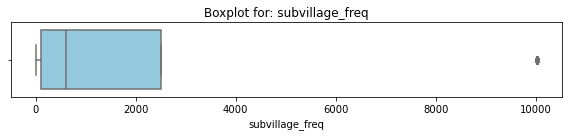

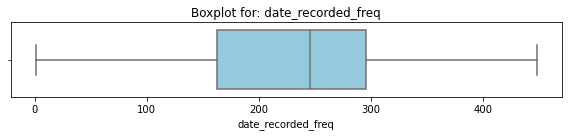

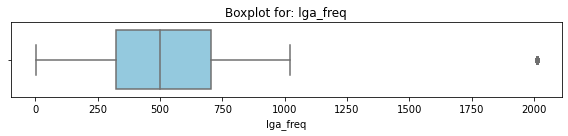

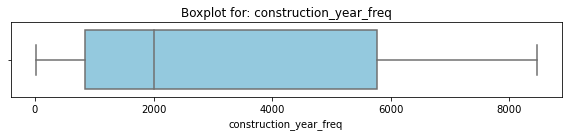

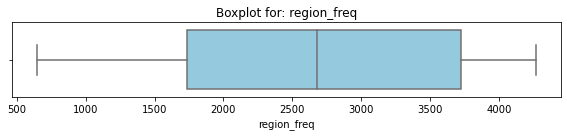

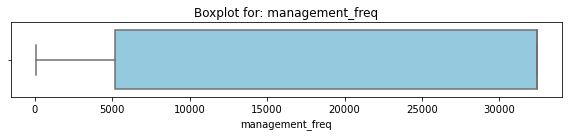

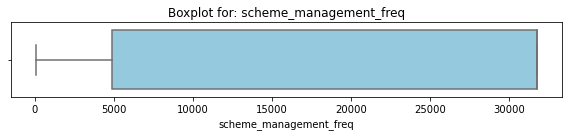

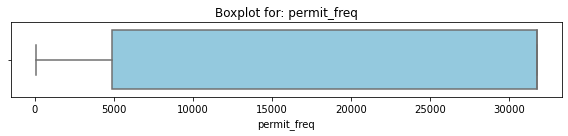

In [49]:
# Loop and plot boxplot for each column
for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_encoded[col], color='skyblue')
    plt.title(f'Boxplot for: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## Detect Outliers (Statistical Methods)

In [50]:
# Cap Outliers Using IQR and Flag Them
def cap_outliers_iqr(df, column):
    # Backup original values
    df[f'{column}_before_clip'] = df[column]

# Calculates lower and upper bounds for acceptable values using IQR
    # Calculate IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Flag which values were outliers
    df[f'{column}_was_outlier'] = (df[column] < lower) | (df[column] > upper)

    # Apply clipping
    df[column] = df[column].clip(lower, upper)

    print(f"{column}: Capped outliers outside [{lower:.2f}, {upper:.2f}]")
    return df

# Apply to selected columns
columns_to_cap = ['amount_tsh', 'population', 'gps_height','longitude', 'latitude']

for col in columns_to_cap:
    df_encoded = cap_outliers_iqr(df_encoded, col)

amount_tsh: Capped outliers outside [-37.50, 62.50]
population: Capped outliers outside [-316.50, 527.50]
gps_height: Capped outliers outside [-1980.00, 3300.00]
longitude: Capped outliers outside [27.26, 43.23]
latitude: Capped outliers outside [-16.39, 4.52]


In [51]:
# Apply Domain-Based Clipping to longitude
# Reasonable Tanzania bounds: longitude between 29 and 41 and latitude -12 to -1
# Clipping helps make location-based features more reliable
print("longitude: Clipping values to range [29, 41] based on valid GPS range for Tanzania")
df_encoded['longitude'] = df_encoded['longitude'].clip(lower=29, upper=41)

print("latitude: Clipping values to range [-12, -1] based on valid GPS range for Tanzania")
df_encoded['latitude'] = df_encoded['latitude'].clip(lower=-12, upper=-1)

longitude: Clipping values to range [29, 41] based on valid GPS range for Tanzania
latitude: Clipping values to range [-12, -1] based on valid GPS range for Tanzania


## Visualize Before vs After

In [52]:
def show_before_after(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 2))
    sns.boxplot(x=df_encoded[f"{col}_before_clip"], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Before Clipping: {col}')
    sns.boxplot(x=df_encoded[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'After Clipping: {col}')
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('')
    plt.tight_layout()
    plt.show()


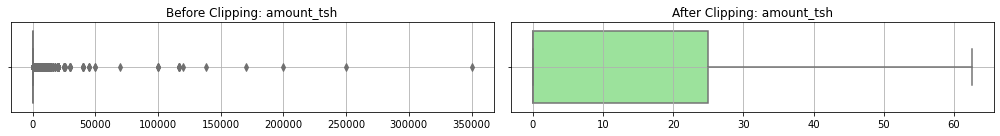

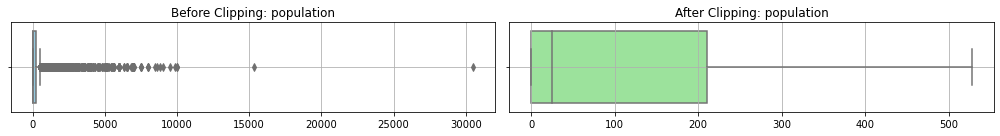

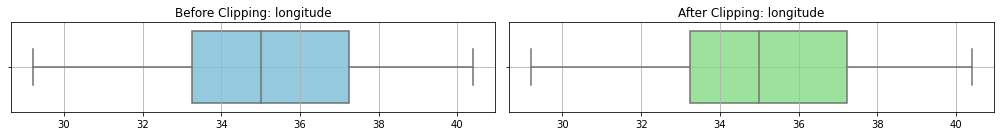

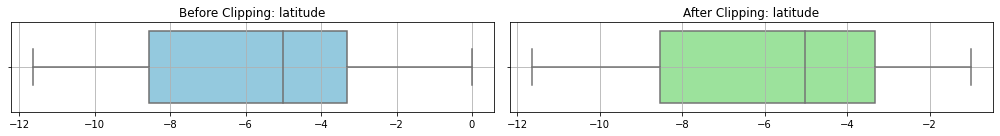

In [53]:
show_before_after('amount_tsh')
show_before_after('population')
show_before_after('longitude')
show_before_after('latitude')

# Normalize / Standardize Numerical Features

th goal is to make sure all the numerical features are on the same scale.

In [54]:
# Select Numeric Columns to Scale
columns_to_scale = ['amount_tsh', 'population', 'gps_height']

In [55]:
# Apply StandardScaler
scaler = StandardScaler()
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])
print(df_encoded[columns_to_scale].describe().T)

              count          mean       std       min       25%       50%  \
amount_tsh  47520.0  6.632741e-16  1.000011 -0.599222 -0.599222 -0.599222   
population  47520.0  4.901733e-16  1.000011 -0.733324 -0.733324 -0.589307   
gps_height  47520.0 -1.789160e-16  1.000011 -1.054700 -0.963807 -0.432874   

                 75%       max  
amount_tsh  0.388346  1.869699  
population  0.482178  2.305432  
gps_height  0.940625  3.032615  


In [56]:
# save the scaler
joblib.dump(scaler, 'standard_scaler.pkl')


['standard_scaler.pkl']

Tip: Numerical features were scaled using StandardScaler to normalize magnitudes and improve model convergence. 

# Build a Data Cleaning Pipeline

In [57]:
# Define the IQRClipper
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds[col]
            X[col] = X[col].clip(lower, upper)
        return X

In [58]:
# setup the column list
# Define your features
numeric_cols = ['amount_tsh', 'population', 'gps_height']
categorical_cols = ['basin', 'payment_type', 'management']
# Boolean columns can often go straight in or be cast to int
boolean_cols = ['permit', 'public_meeting']

In [59]:
# define the pipelines

# Numeric preprocessing
numeric_pipeline = Pipeline([
    ('iqr_clip', IQRClipper(columns=numeric_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Boolean preprocessing (optional: cast to int or handle as-is)
boolean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


In [60]:
# combine into full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols),
    ('bool', boolean_pipeline, boolean_cols)
])


In [61]:
# wrap the final pipeline 
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


In [62]:
# save the pipeline for later use
joblib.dump(final_pipeline, 'data_cleaning_pipeline.pkl')


['data_cleaning_pipeline.pkl']

In [63]:
print(df_train.columns.tolist())

['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type_class', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'status_group', 'year_recorded', 'month_recorded', 'dayofweek_recorded']


In [64]:
# Now that booleans are numeric, include them in numeric pipeline
numeric_cols = ['amount_tsh', 'population', 'gps_height', 'permit', 'public_meeting']
categorical_cols = ['basin', 'payment_type', 'management']


In [65]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [66]:
print(final_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iqr_clip',
                                                                   IQRClipper(columns=['amount_tsh',
                                                                                       'population',
                                                                                       'gps_height'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population',
                                                   'gps_height']),
                                  

In [67]:
from sklearn import set_config
set_config(display='diagram')
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('iqr_clip',
                                                                   IQRClipper(columns=['amount_tsh',
                                                                                       'population',
                                                                                       'gps_height'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population',
                                                   'gps_height']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['basin', 'payment_type',
                                                   'management']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])]))])